##**Pre-setting** :

###Import and Define function:

In [53]:
import datetime as dt
import pandas_datareader.data as dr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
#import keras_tuner as kt
#from pandas_datareader.yahoo.daily import YahooDailyReader
from sklearn.preprocessing import MinMaxScaler

#import measure
import math
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import r2_score as R2
def RMSE(y_true,y_false):
  return math.sqrt(MSE(y_true,y_false))
def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


#import Model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble  import RandomForestRegressor
from sklearn.ensemble  import AdaBoostRegressor
from sklearn.ensemble  import VotingRegressor
from sklearn.svm import LinearSVR
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

import tensorflow as tf

In [3]:
def moving_average (list_price,n):
  ma_list = [None]*len(list_price)
  for i in range(len(list_price)):
    if i < n - 1 :
      ma_list[i] = 0
    elif i == n-1 :
      ma_list[i] = sum(list_price[i-n+1:i+1])/n
    else :
      ma_list[i] = ma_list[i-1] + list_price[i]/n - list_price[i-n]/n
  return ma_list

  
def ma(df,periods=50, ema = False):
  if ema == True:
	    # Use exponential moving average
      ma_list = df.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
  else:
      # Use simple moving average
      ma_list = df.rolling(window = periods).mean()
  return ma_list;


def rsi(df, periods = 14, ema = True):
    """
    Returns a pd.Series with the relative strength index.
    """
    close_delta = df.diff()

    # Make two series: one for lower closes and one for higher closes
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)

    if ema == True:
	    # Use exponential moving average
        ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
        ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    else:
        # Use simple moving average
        ma_up = up.rolling(window = periods, adjust=False).mean()
        ma_down = down.rolling(window = periods, adjust=False).mean()
        
    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    return rsi

def macd(price, slow, fast, smooth):
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    db_macd = pd.DataFrame(exp1 - exp2)
    signal = pd.DataFrame(db_macd.ewm(span = smooth, adjust = False).mean())
    hist = pd.DataFrame(db_macd - signal)
    df = pd.DataFrame(db_macd).rename(columns = {order[3]+'_'+stock[0]:'MACD'})
    #df[('MACD','macd')]=db_macd
    df['signal']=signal
    df['hist']=hist
    return df




In [4]:
def plot(X,Ytest=None,Ypred=None,Y3=None,Xtrain=None,Ytrain=None,Title=None,Xlabel=None,Ylabel=None):
  plt.style.use('seaborn')
  plt.figure(figsize=(32,16))
  
  if type(Ytest) is not type(None):
    plt.plot(X,Ytest, '-b', markersize=20, label = 'Actual')

  if type(Ypred) is not type(None):
    plt.plot(X,Ypred, '-r', markersize=15, label = 'Predict')

  if type(Y3) is not type(None):
    plt.plot(X,Y3, '-g', markersize=15, label = 'Y3')

  if type(Ytrain) is not type(None) and type(Xtrain) is not type(None):
    plt.plot(Xtrain,Ytrain, '-b', markersize=15)

    
  plt.title(Title,fontsize=18)
  plt.xlabel(Xlabel,fontsize=16)
  plt.ylabel(Ylabel,fontsize=16)
  plt.legend(loc="upper left",fontsize= 'large')
  

def result(y_true,y_pred, name=''):
  rmse_pred = RMSE(y_true,y_pred)
  mae_pred = MAE(y_true,y_pred)
  mape_pred = MAPE(y_true,y_pred)
  print(name,'RMSE:', rmse_pred)
  print(name,'MAE: ', mae_pred)
  print(name,'MAPE:', mape_pred)


###Link and Important variable

In [5]:

!python --version
print(tf.__version__)


Python 3.7.12
2.6.0


In [6]:
#symbol of stock to predict.
#The first symbol will be the prediction target
stock = ['ENPH', '^NDQ', '^SPX']
#stock = ['TSLA']

#value need to predict
order = ['Open', 'High', 'Low', 'Close']

#moving average to add
ma_list =[20,50,100,200]

#terget to predict price
target = [order[3]+'_'+stock[0],order[0]+'_'+stock[0],order[1]+'_'+stock[0],order[2]+'_'+stock[0]]

> Read Stock: [pandas-datareader](https://pandas-datareader.readthedocs.io/en/latest/)\
> Pandas: [pandas.DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html)\
> Sklearn: [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)\
> Tensorflow: [Tensorflow](https://www.tensorflow.org/tutorials/keras/regression)

###Note:

##**Preprocessing**

In [7]:
rawdb = dr.DataReader(stock,'stooq', start='01-01-2008', end=dt.datetime.today() )
rawdb

Attributes   Close                     ...     Volume                            
Symbols       ENPH      ^NDQ     ^SPX  ...       ENPH          ^NDQ          ^SPX
Date                                   ...                                       
2008-01-02     NaN   2609.62  1447.16  ...        NaN  1.931322e+09  1.918139e+09
2008-01-03     NaN   2602.67  1447.16  ...        NaN  1.832286e+09  1.905278e+09
2008-01-04     NaN   2504.64  1411.63  ...        NaN  2.340168e+09  2.314444e+09
2008-01-07     NaN   2499.46  1416.18  ...        NaN  2.418093e+09  2.345144e+09
2008-01-08     NaN   2440.51  1390.18  ...        NaN  2.386826e+09  2.614106e+09
...            ...       ...      ...  ...        ...           ...           ...
2021-10-08  154.36  14579.54  4391.34  ...  1205274.0  2.418202e+09  1.683911e+09
2021-10-11  161.26  14486.20  4361.19  ...  2146138.0  2.310298e+09  1.684626e+09
2021-10-12  169.84  14465.92  4350.65  ...  2438486.0  2.521293e+09  1.951342e+09
2021-10-13  173.21  14571.63  4363.80  ...  2119885.0  2.564598e+09  1.928089e+09
2021-10-14  173.78  14823.43  4438.26  ...  1541626.0  2.697707e+09  1.939303e+09

[3473 rows x 15 columns]

In [8]:
rawdb.dropna(inplace=True)
rawdb.shape

(2402, 15)

In [9]:
#Modified the order of the columns
#db = rawdb[[ (order[0],stock[0]),(order[1],stock[0]),(order[2],stock[0]), (order[3],stock[0])   ]]
db = rawdb[[ (order[0],stock[0])]]
db.columns = ['{}_{}'.format(x[0], x[1]) for x in db.columns]
for i in stock:
 for j in order:
   string = j+'_'+i
   db[string] = rawdb[[(j,i)]]
   db[string+'_lg'] = np.log(1+db[string].pct_change())

db.tail()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,Open_ENPH,Open_ENPH_lg,High_ENPH,High_ENPH_lg,Low_ENPH,Low_ENPH_lg,Close_ENPH,Close_ENPH_lg,Open_^NDQ,Open_^NDQ_lg,High_^NDQ,High_^NDQ_lg,Low_^NDQ,Low_^NDQ_lg,Close_^NDQ,Close_^NDQ_lg,Open_^SPX,Open_^SPX_lg,High_^SPX,High_^SPX_lg,Low_^SPX,Low_^SPX_lg,Close_^SPX,Close_^SPX_lg
Date,,,,,,,,,,,,,,,,,,,,,,,,
2021-10-08,158.46,0.014557,159.5000,-0.020048,153.59,-0.015569,154.36,-0.018422,14694.72,0.004291,14699.91,-0.003789,14569.68,-0.003115,14579.54,-0.005096,4406.51,0.005183,4412.02,-0.004060,4386.22,0.000568,4391.34,-0.001916
2021-10-11,154.75,-0.023691,165.4564,0.036664,154.75,0.007524,161.26,0.043730,14540.08,-0.010579,14665.99,-0.002310,14482.62,-0.005993,14486.20,-0.006423,4385.44,-0.004793,4415.88,0.000875,4360.59,-0.005860,4361.19,-0.006889
2021-10-12,162.12,0.046526,172.1000,0.039368,162.12,0.046526,169.84,0.051839,14539.09,-0.000068,14552.71,-0.007754,14441.60,-0.002836,14465.92,-0.001401,4368.31,-0.003914,4374.89,-0.009326,4342.09,-0.004252,4350.65,-0.002420
2021-10-13,171.93,0.058751,175.9100,0.021897,169.82,0.046402,173.21,0.019648,14537.17,-0.000132,14589.28,0.002510,14471.88,0.002095,14571.63,0.007281,4358.01,-0.002361,4372.87,-0.000462,4329.92,-0.002807,4363.80,0.003018
2021-10-14,175.60,0.021121,176.6303,0.004086,170.44,0.003644,173.78,0.003285,14717.50,0.012328,14827.55,0.016200,14699.52,0.015607,14823.43,0.017133,4386.75,0.006573,4439.73,0.015174,4386.75,0.013040,4438.26,0.016919


In [10]:
db.shape

(2402, 24)

In [11]:
#add Indicator
db['Moving Average'+'_'+'20'] = ma(db[target[0]],20)
db['Moving Average'+'_'+'50'] = ma(db[target[0]],50)
db['Moving Average'+'_'+'100'] = ma(db[target[0]],100)
db['Moving Average'+'_'+'200'] = ma(db[target[0]],200)
db['RSI'] = rsi(db[target[0]], 14,True  )
macd_frame = macd(db[target[0]],26,12,9)
db = pd.concat([db,macd_frame],axis=1,verify_integrity=True)
db

,Open_ENPH,Open_ENPH_lg,High_ENPH,High_ENPH_lg,Low_ENPH,Low_ENPH_lg,Close_ENPH,Close_ENPH_lg,Open_^NDQ,Open_^NDQ_lg,High_^NDQ,High_^NDQ_lg,Low_^NDQ,Low_^NDQ_lg,Close_^NDQ,Close_^NDQ_lg,Open_^SPX,Open_^SPX_lg,High_^SPX,High_^SPX_lg,Low_^SPX,Low_^SPX_lg,Close_^SPX,Close_^SPX_lg,Moving Average_20,Moving Average_50,Moving Average_100,Moving Average_200,RSI,MACD,signal,hist
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012-03-30,7.50,NaN,8.2400,NaN,7.06,NaN,7.34,NaN,3110.97,NaN,3111.55,NaN,3079.05,NaN,3091.57,NaN,1403.31,NaN,1410.89,NaN,1401.42,NaN,1408.47,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
2012-04-02,7.65,0.019803,8.2000,-0.004866,7.40,0.047035,7.81,0.062066,3085.94,-0.008078,3123.03,0.003683,3079.78,0.000237,3119.70,0.009058,1408.47,0.003670,1422.38,0.008111,1404.46,0.002167,1419.04,0.007477,NaN,NaN,NaN,NaN,NaN,0.037493,0.007499,0.029994
2012-04-03,7.75,0.012987,7.8000,-0.050010,7.50,0.013423,7.64,-0.022007,3119.65,0.010865,3128.25,0.001670,3097.41,0.005708,3113.57,-0.001967,1418.98,0.007434,1419.00,-0.002379,1404.62,0.000114,1413.38,-0.003997,NaN,NaN,NaN,NaN,NaN,0.052879,0.016575,0.036304
2012-04-04,7.77,0.002577,7.7700,-0.003854,7.31,-0.025660,7.45,-0.025184,3085.46,-0.011020,3086.35,-0.013485,3052.58,-0.014579,3068.09,-0.014715,1413.09,-0.004160,1413.09,-0.004174,1394.09,-0.007525,1398.96,-0.010255,NaN,NaN,NaN,NaN,NaN,0.049175,0.023095,0.026080
2012-04-05,7.48,-0.038037,7.5500,-0.028723,7.37,0.008174,7.41,-0.005384,3061.75,-0.007714,3083.38,-0.000963,3061.14,0.002800,3080.50,0.004037,1398.79,-0.010171,1401.60,-0.008164,1392.92,-0.000840,1398.08,-0.000629,NaN,NaN,NaN,NaN,NaN,0.042521,0.026980,0.015541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-08,158.46,0.014557,159.5000,-0.020048,153.59,-0.015569,154.36,-0.018422,14694.72,0.004291,14699.91,-0.003789,14569.68,-0.003115,14579.54,-0.005096,4406.51,0.005183,4412.02,-0.004060,4386.22,0.000568,4391.34,-0.001916,154.2640,166.6856,164.4568,165.70535,46.690896,-3.794681,-4.641542,0.846860
2021-10-11,154.75,-0.023691,165.4564,0.036664,154.75,0.007524,161.26,0.043730,14540.08,-0.010579,14665.99,-0.002310,14482.62,-0.005993,14486.20,-0.006423,4385.44,-0.004793,4415.88,0.000875,4360.59,-0.005860,4361.19,-0.006889,154.3225,166.1188,164.7627,165.61005,53.380614,-2.893148,-4.291863,1.398715
2021-10-12,162.12,0.046526,172.1000,0.039368,162.12,0.046526,169.84,0.051839,14539.09,-0.000068,14552.71,-0.007754,14441.60,-0.002836,14465.92,-0.001401,4368.31,-0.003914,4374.89,-0.009326,4342.09,-0.004252,4350.65,-0.002420,154.9170,165.8534,165.0429,165.55230,60.087730,-1.469403,-3.727371,2.257968


In [12]:
db.dropna(inplace=True)
db.shape

(2203, 32)

In [13]:

db.tail(10)

,Open_ENPH,Open_ENPH_lg,High_ENPH,High_ENPH_lg,Low_ENPH,Low_ENPH_lg,Close_ENPH,Close_ENPH_lg,Open_^NDQ,Open_^NDQ_lg,High_^NDQ,High_^NDQ_lg,Low_^NDQ,Low_^NDQ_lg,Close_^NDQ,Close_^NDQ_lg,Open_^SPX,Open_^SPX_lg,High_^SPX,High_^SPX_lg,Low_^SPX,Low_^SPX_lg,Close_^SPX,Close_^SPX_lg,Moving Average_20,Moving Average_50,Moving Average_100,Moving Average_200,RSI,MACD,signal,hist
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-10-01,152.02,0.012111,155.9600,0.027497,150.5600,0.017149,155.36,0.035310,14494.93,-0.006030,14606.82,-0.001747,14324.01,-0.008363,14566.70,0.008142,4317.16,-0.012319,4375.19,-0.001681,4288.52,-0.004123,4357.04,0.011426,157.6650,169.3574,162.8056,166.11375,44.297542,-4.913451,-4.857051,-0.056400
2021-10-04,153.54,0.009949,153.7200,-0.014467,144.4700,-0.041290,145.03,-0.068804,14493.13,-0.000124,14499.73,-0.007359,14181.69,-0.009985,14255.48,-0.021597,4348.84,0.007311,4355.51,-0.004508,4278.94,-0.002236,4300.46,-0.013071,156.2195,168.6944,163.0842,166.02235,35.414600,-5.333886,-4.952418,-0.381468
2021-10-05,146.00,-0.050354,149.7300,-0.026299,144.9000,0.002972,147.41,0.016277,14312.86,-0.012516,14508.65,0.000615,14299.78,0.008292,14433.83,0.012433,4309.87,-0.009001,4369.23,0.003145,4309.87,0.007202,4345.72,0.010469,155.1535,168.1090,163.4122,165.94180,38.475752,-5.412643,-5.044463,-0.368180
2021-10-06,144.36,-0.011296,155.8500,0.040060,143.4487,-0.010066,153.58,0.041004,14289.45,-0.001637,14509.55,0.000062,14259.07,-0.002851,14501.91,0.004706,4319.57,0.002248,4365.57,-0.000838,4290.49,-0.004507,4363.55,0.004094,154.6635,167.7234,163.7502,165.88765,45.665578,-4.920471,-5.019665,0.099193
2021-10-07,156.17,0.078635,162.7300,0.043198,156.0000,0.083879,157.23,0.023488,14631.80,0.023676,14755.72,0.016824,14615.14,0.024665,14654.02,0.010434,4383.73,0.014744,4429.97,0.014644,4383.73,0.021499,4399.76,0.008264,154.4570,167.2396,164.1383,165.81990,49.430478,-4.187625,-4.853257,0.665632
2021-10-08,158.46,0.014557,159.5000,-0.020048,153.5900,-0.015569,154.36,-0.018422,14694.72,0.004291,14699.91,-0.003789,14569.68,-0.003115,14579.54,-0.005096,4406.51,0.005183,4412.02,-0.004060,4386.22,0.000568,4391.34,-0.001916,154.2640,166.6856,164.4568,165.70535,46.690896,-3.794681,-4.641542,0.846860
2021-10-11,154.75,-0.023691,165.4564,0.036664,154.7500,0.007524,161.26,0.043730,14540.08,-0.010579,14665.99,-0.002310,14482.62,-0.005993,14486.20,-0.006423,4385.44,-0.004793,4415.88,0.000875,4360.59,-0.005860,4361.19,-0.006889,154.3225,166.1188,164.7627,165.61005,53.380614,-2.893148,-4.291863,1.398715
2021-10-12,162.12,0.046526,172.1000,0.039368,162.1200,0.046526,169.84,0.051839,14539.09,-0.000068,14552.71,-0.007754,14441.60,-0.002836,14465.92,-0.001401,4368.31,-0.003914,4374.89,-0.009326,4342.09,-0.004252,4350.65,-0.002420,154.9170,165.8534,165.0429,165.55230,60.087730,-1.469403,-3.727371,2.257968
2021-10-13,171.93,0.058751,175.9100,0.021897,169.8200,0.046402,173.21,0.019648,14537.17,-0.000132,14589.28,0.002510,14471.88,0.002095,14571.63,0.007281,4358.01,-0.002361,4372.87,-0.000462,4329.92,-0.002807,4363.80,0.003018,155.8010,165.4652,165.3522,165.54090,62.377263,-0.068357,-2.995568,2.927211


In [14]:
#normalize using tensorflow
#normalized_df=(db_close-db_close.mean())/db_close.std()
#normalized_df=(df-df.min())/(df.max()-df.min())

#normalize using MinMax scaler
scaler = MinMaxScaler(feature_range=(0,1)).fit(db)
db_scaled = pd.DataFrame(scaler.transform(db),index=db.index,columns=db.columns)
db_scaled

,Open_ENPH,Open_ENPH_lg,High_ENPH,High_ENPH_lg,Low_ENPH,Low_ENPH_lg,Close_ENPH,Close_ENPH_lg,Open_^NDQ,Open_^NDQ_lg,High_^NDQ,High_^NDQ_lg,Low_^NDQ,Low_^NDQ_lg,Close_^NDQ,Close_^NDQ_lg,Open_^SPX,Open_^SPX_lg,High_^SPX,High_^SPX_lg,Low_^SPX,Low_^SPX_lg,Close_^SPX,Close_^SPX_lg,Moving Average_20,Moving Average_50,Moving Average_100,Moving Average_200,RSI,MACD,signal,hist
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-16,0.014608,0.632964,0.013927,0.420165,0.015152,0.639453,0.014789,0.572583,0.000000,0.576641,0.000000,0.529527,0.000117,0.569459,0.000105,0.605250,0.000000,0.550563,0.000000,0.508785,0.000000,0.583861,0.000000,0.588257,0.014134,0.012020,0.016359,0.024630,0.676837,0.402817,0.361447,0.599516
2013-01-17,0.014470,0.589274,0.014102,0.436732,0.015104,0.613714,0.015071,0.588239,0.001612,0.593009,0.001580,0.548149,0.001669,0.579690,0.001611,0.622154,0.000098,0.543547,0.003646,0.564991,0.001645,0.589019,0.002712,0.613243,0.014268,0.012071,0.016294,0.024526,0.698557,0.402840,0.361512,0.599407
2013-01-18,0.014793,0.625338,0.014278,0.436629,0.014864,0.598923,0.014461,0.528264,0.001402,0.556672,0.000821,0.471536,0.001131,0.531757,0.001506,0.593557,0.002814,0.584761,0.003913,0.509659,0.002686,0.580883,0.004357,0.602984,0.014419,0.012098,0.016224,0.024404,0.613943,0.402417,0.361466,0.598168
2013-01-22,0.014286,0.560317,0.013708,0.393389,0.014672,0.602435,0.014461,0.569418,0.002031,0.573367,0.001509,0.518890,0.001322,0.548462,0.002197,0.607639,0.004456,0.567736,0.006055,0.540142,0.004436,0.590286,0.006504,0.607680,0.014578,0.012152,0.016156,0.024287,0.613943,0.402008,0.361334,0.597214
2013-01-23,0.014194,0.592770,0.013489,0.413492,0.014720,0.621126,0.014179,0.549944,0.003677,0.593430,0.002965,0.543823,0.003626,0.596605,0.003053,0.610508,0.006605,0.575535,0.007217,0.524143,0.007295,0.604859,0.007238,0.594282,0.014752,0.012287,0.016074,0.024174,0.574983,0.401450,0.361100,0.596063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-08,0.727012,0.620443,0.695441,0.406579,0.733349,0.595685,0.721207,0.546996,0.944456,0.582634,0.942704,0.464670,0.936787,0.525889,0.935162,0.572347,0.957928,0.581340,0.956434,0.473295,0.954715,0.570658,0.952482,0.578537,0.774110,0.882771,0.964839,0.997370,0.440725,0.264676,0.168096,0.693186
2021-10-11,0.709915,0.567077,0.721528,0.463055,0.738911,0.627858,0.753592,0.622641,0.931848,0.507165,0.939941,0.477045,0.929673,0.509081,0.927547,0.566337,0.951049,0.505622,0.957691,0.512202,0.946331,0.529297,0.942643,0.555651,0.774405,0.879755,0.966643,0.996793,0.530432,0.295783,0.182056,0.754768
2021-10-12,0.743879,0.665048,0.750624,0.465748,0.774251,0.682193,0.793862,0.632510,0.931767,0.560511,0.930715,0.431505,0.926321,0.527518,0.925893,0.589076,0.945456,0.512295,0.944347,0.431779,0.940279,0.539648,0.939203,0.576218,0.777403,0.878342,0.968296,0.996443,0.620372,0.344910,0.204593,0.850653


In [15]:
n = len(order)*len(stock)
for i in range(n):
  print(i//4)

0
0
0
0
1
1
1
1
2
2
2
2


In [16]:
#not normalize
y_close = db[target[0]].shift(-1)
y_multi = db[[target[1],target[2],target[3],target[0]]].shift(-1)
x_close = db
#normalize
#y_close = db_scaled['label']
#x_close = db_scaled.drop('label',axis=1)

In [17]:
x_today = x_close.tail(1)
x_close.drop(x_close.tail(1).index,inplace=True)
y_close.drop(y_close.tail(1).index,inplace=True)
y_multi.drop(y_multi.tail(1).index,inplace=True)
x_today

,Open_ENPH,Open_ENPH_lg,High_ENPH,High_ENPH_lg,Low_ENPH,Low_ENPH_lg,Close_ENPH,Close_ENPH_lg,Open_^NDQ,Open_^NDQ_lg,High_^NDQ,High_^NDQ_lg,Low_^NDQ,Low_^NDQ_lg,Close_^NDQ,Close_^NDQ_lg,Open_^SPX,Open_^SPX_lg,High_^SPX,High_^SPX_lg,Low_^SPX,Low_^SPX_lg,Close_^SPX,Close_^SPX_lg,Moving Average_20,Moving Average_50,Moving Average_100,Moving Average_200,RSI,MACD,signal,hist
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-10-14,175.6,0.021121,176.6303,0.004086,170.44,0.003644,173.78,0.003285,14717.5,0.012328,14827.55,0.0162,14699.52,0.015607,14823.43,0.017133,4386.75,0.006573,4439.73,0.015174,4386.75,0.01304,4438.26,0.016919,156.6505,165.0622,165.6813,165.5588,62.766313,1.075578,-2.181339,3.256917


In [18]:
print(x_close.shape)
print(y_close.shape)

(2202, 32)
(2202,)


In [19]:
x_close_train, x_close_test, y_close_train, y_close_test = train_test_split(x_close,y_close,test_size=0.25,random_state = 0,shuffle= False)
print(x_close_train.shape)
print(x_close_test.shape)
print(y_close_train.shape)
print(y_close_test.shape)

(1651, 32)
(551, 32)
(1651,)
(551,)


##**Training**

###Model: Linear Regression using Least Square


In [20]:
#using Theta best version

'''
theta_best = np.linalg.inv(x_close_train.T.dot(x_close_train)).dot(x_close_train.T).dot(y_close_train)
print(theta_best)
y_close_pred_ls = x_close_test.dot(theta_best)
'''


'\ntheta_best = np.linalg.inv(x_close_train.T.dot(x_close_train)).dot(x_close_train.T).dot(y_close_train)\nprint(theta_best)\ny_close_pred_ls = x_close_test.dot(theta_best)\n'

In [21]:
#using sklearn
ls_model = LinearRegression()
ls_model.fit(x_close_train,y_close_train)
y_close_pred_ls = ls_model.predict(x_close_test.sort_index())

In [22]:
result(y_close_test,y_close_pred_ls, 'LS')

LS RMSE: 4.9968485955174975
LS MAE:  3.2859992648191496
LS MAPE: 3.760139665490773


#### Graph for Linear Regression using Least Square

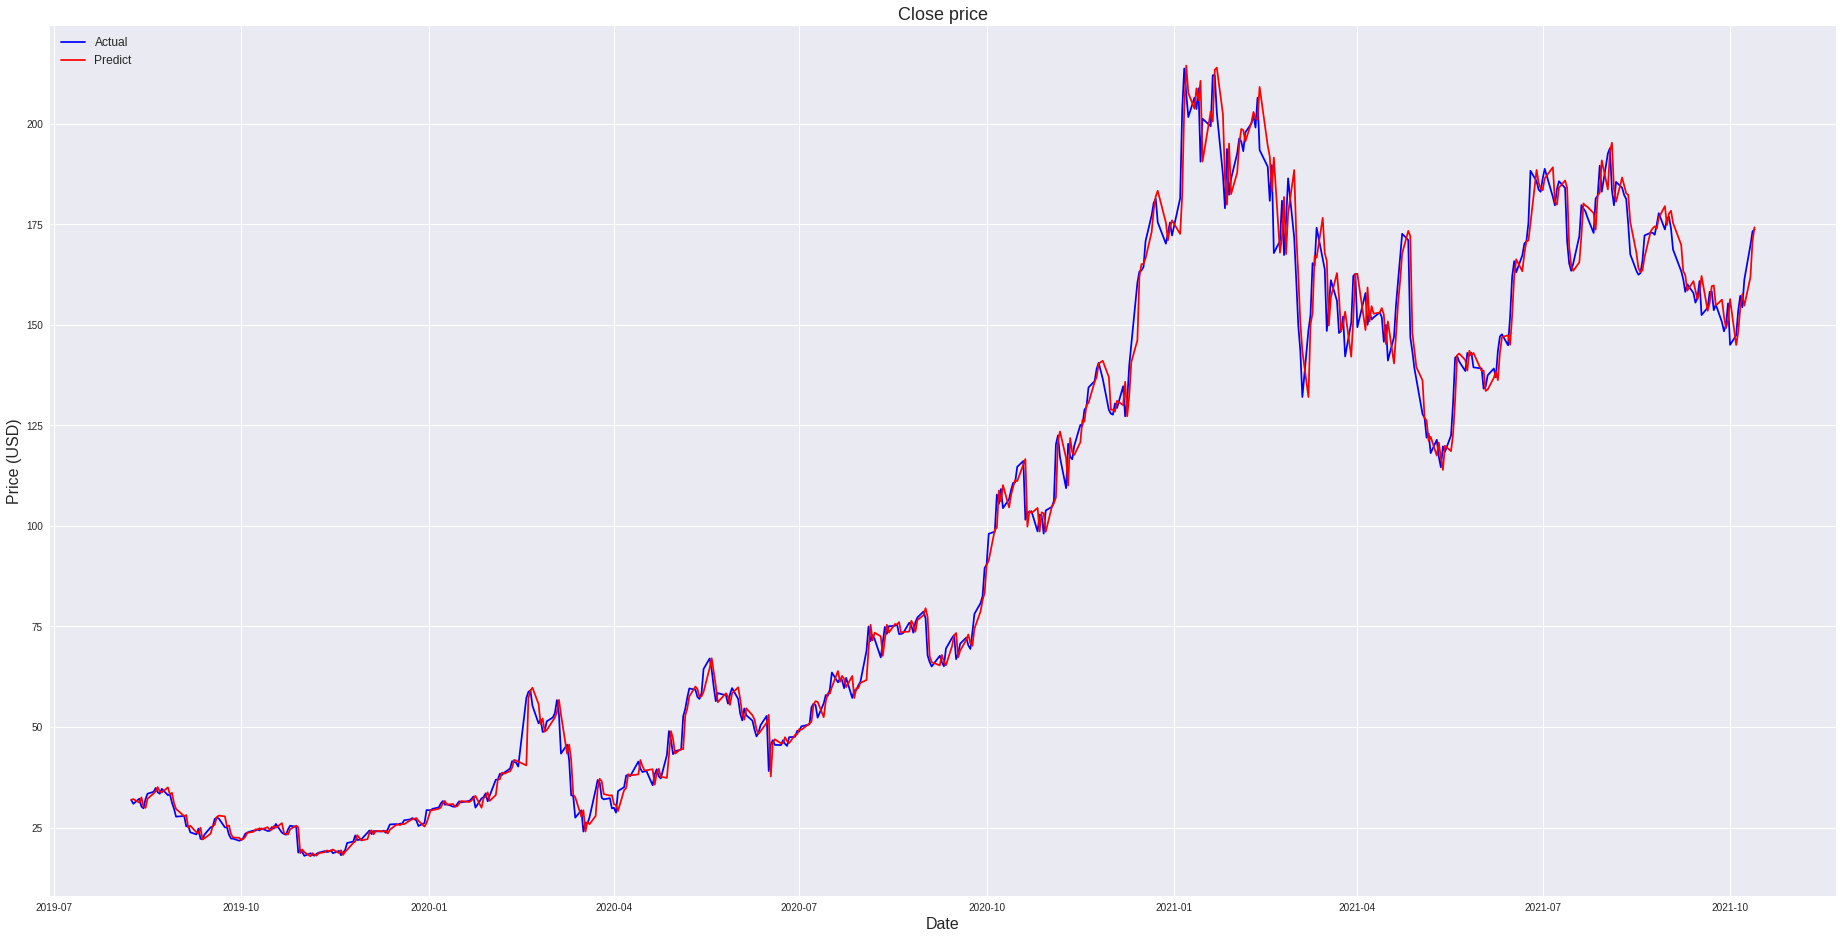

In [23]:
plot( y_close_test.sort_index().index,
     y_close_test.sort_index(),
     y_close_pred_ls,
     #y_close_pred_ts,
     #Xtrain = y_close_train.sort_index().index,
     Ytrain = y_close_train.sort_index(),
     Title = "Close price",
     Xlabel = 'Date',
     Ylabel = 'Price (USD)' 
)

###Model: Ada Boost Regression (sklearn)

In [24]:

ada_model = AdaBoostRegressor(base_estimator=Ridge() , loss='exponential',learning_rate=0.1, n_estimators=100)
ada_model.fit(x_close_train,y_close_train)

AdaBoostRegressor(base_estimator=Ridge(alpha=1.0, copy_X=True,
                                       fit_intercept=True, max_iter=None,
                                       normalize=False, random_state=None,
                                       solver='auto', tol=0.001),
                  learning_rate=0.1, loss='exponential', n_estimators=100,
                  random_state=None)

In [25]:
y_close_pred_ada = ada_model.predict(x_close_test.sort_index())

In [26]:
result(y_close_test,y_close_pred_ada)

 RMSE: 9.16273623961421
 MAE:  6.317866995513144
 MAPE: 6.913091192055619


####Tuning

In [27]:
ada_model = RandomForestRegressor()
'''
parameter = {
    'n_estimators':[100],
    #'criterion': ['squared_error', 'mse', 'absolute_error', 'poisson'],
    'max_depth': [None,10,20],
    'min_samples_split' : [2,3,5],
    'min_samples_leaf' : [1,5,6],
    'min_weight_fraction_leaf': [0.0],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_leaf_nodes' : [None,5,6],
    'min_impurity_decrease': [0.0,0.2],
}
'''
'''
parameter = {
    'n_estimators' :np.arange(0,5000,50),
    'max_depth' : np.arange(0,5000,50),
    'min_samples_split' : np.arange(0,3000,30),
    'min_samples_leaf' : np.arange(0,1000,10),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_leaf_nodes' : np.arange(0,5000,20),
    'min_impurity_decrease': np.arange(0,1,0.005),
}
ada_search = RandomizedSearchCV(ada_model,parameter,verbose=True,n_iter=5,n_jobs=-1,scoring='neg_mean_squared_error')
best_ada = ada_search.fit(x_close_train,y_close_train)

print('\nBest Parameters: ' + str(best_ada.best_params_))
'''

"\nparameter = {\n    'n_estimators' :np.arange(0,5000,50),\n    'max_depth' : np.arange(0,5000,50),\n    'min_samples_split' : np.arange(0,3000,30),\n    'min_samples_leaf' : np.arange(0,1000,10),\n    'max_features': ['auto', 'sqrt', 'log2'],\n    'max_leaf_nodes' : np.arange(0,5000,20),\n    'min_impurity_decrease': np.arange(0,1,0.005),\n}\nada_search = RandomizedSearchCV(ada_model,parameter,verbose=True,n_iter=5,n_jobs=-1,scoring='neg_mean_squared_error')\nbest_ada = ada_search.fit(x_close_train,y_close_train)\n\nprint('\nBest Parameters: ' + str(best_ada.best_params_))\n"

In [28]:
'''
ada_best_model = best_ada.best_estimator_
ada_best_model.fit(x_close_train,y_close_train)
y_close_pred_best_ada = ada_best_model.predict(x_close_test.sort_index())
'''

'\nada_best_model = best_ada.best_estimator_\nada_best_model.fit(x_close_train,y_close_train)\ny_close_pred_best_ada = ada_best_model.predict(x_close_test.sort_index())\n'

In [29]:
#result(y_close_test,y_close_pred_best_ada)

####Graph for Ada Boosting

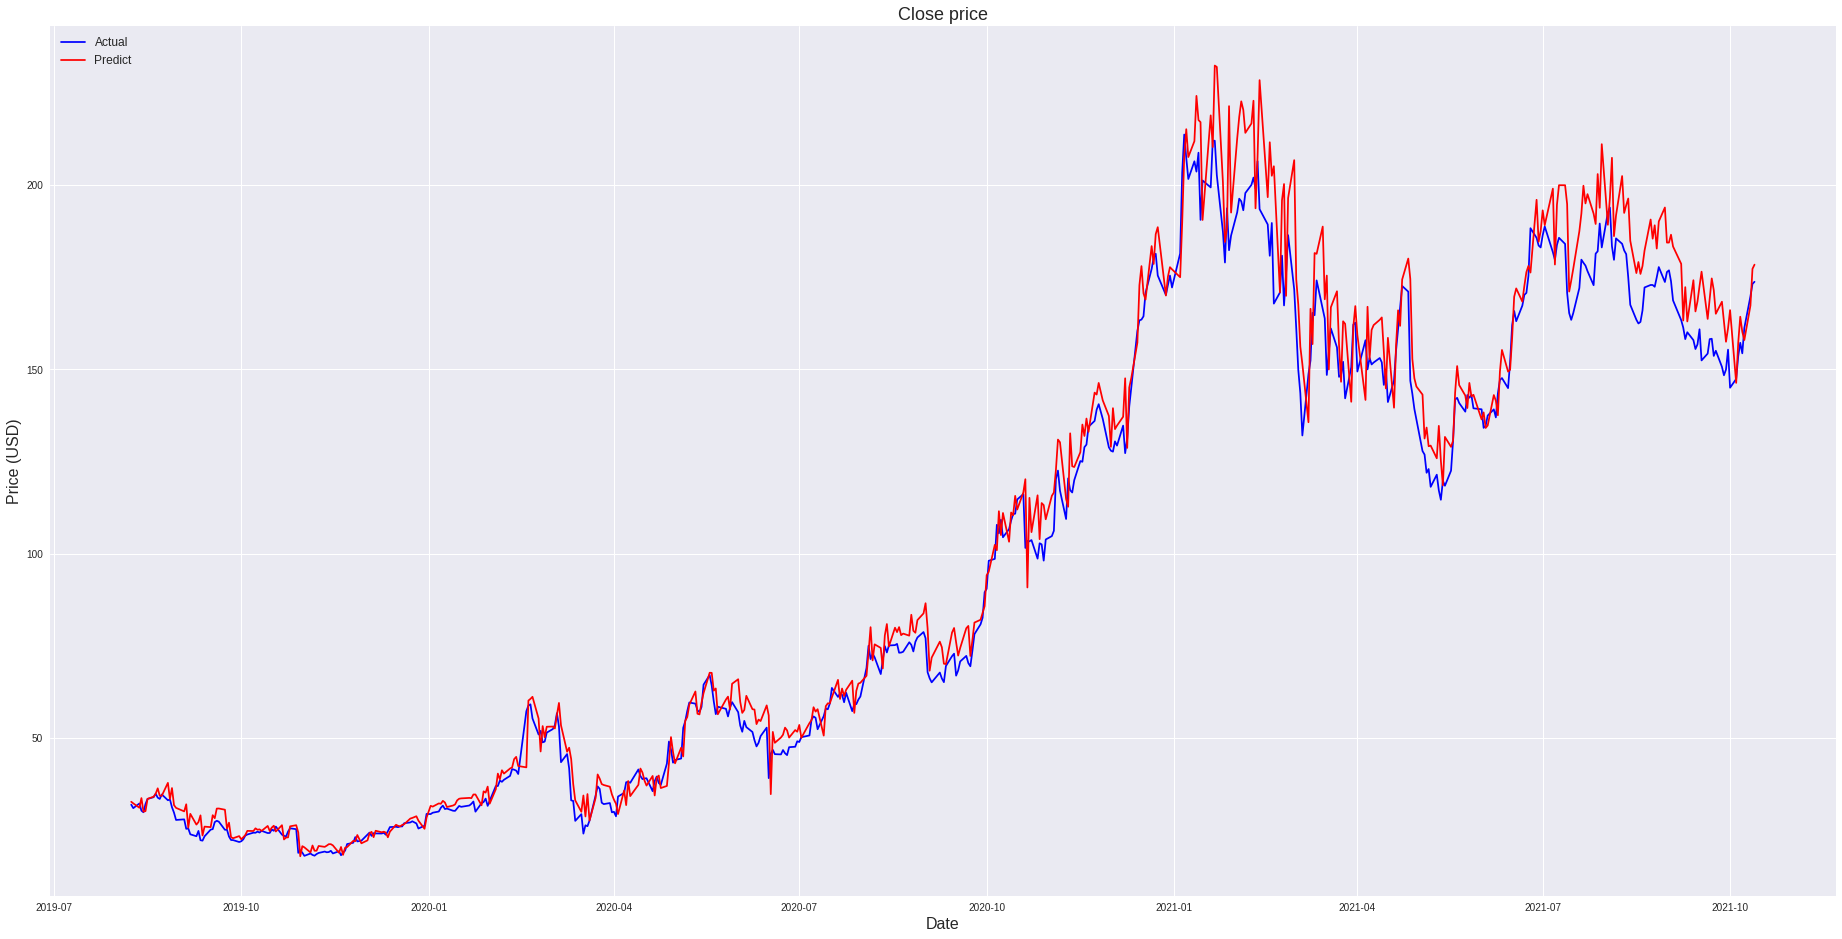

In [30]:
plot( y_close_test.sort_index().index,
     y_close_test.sort_index(),
     y_close_pred_ada,
     #Xtrain = y_close_train.sort_index().index,
     Ytrain = y_close_train.sort_index(),
     Title = "Close price",
     Xlabel = 'Date',
     Ylabel = 'Price (USD)' 
)

###Model: Support Vector Machine Regression (sklearn)

In [54]:
#Best Parameters: {'kernel': 'linear', 'gamma': 'scale', 'epsilon': 3.9000000000000004, 'coef0': 0.6699999999999997, 'C': 20.6}
svr_model = LinearSVR()
svr_model.fit(x_close_train,y_close_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=None, tol=0.0001, verbose=0)

In [47]:
y_close_pred_svr = svr_model.predict(x_close_test.sort_index())


In [48]:
result(y_close_test,y_close_pred_svr)


 RMSE: 166.16390056840189
 MAE:  118.80356941671228
 MAPE: 141.76463337978217


####Fine-tuning

In [64]:
'''
parameter = {
    'kernel' : ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
    'degree' :[3]
    'gamma' :['scale', 'auto', 0.1, 0.01, 0.001],
    'coef0' : [0.1,0.5,1.0],
    'tol' : [1e-3,1e-5,1e-1,0],
    'C' : [0.1,1,10],
    'epsilon' : [0.1,1,10,100],
    'shrinking': [True,False],
    
}
'''

svr_model = LinearSVR()
parameter = {
    'epsilon' : np.arange(0.1,500,0.1),
    'C' : np.arange(0.1,1000,0.1),
    'loss' : ['epsilon_insensitive', 'squared_epsilon_insensitive'], 
}
svr_search = RandomizedSearchCV(svr_model,parameter,verbose=True,n_iter=500,n_jobs=-1,scoring='neg_mean_squared_error')
best_svr = svr_search.fit(x_close_train,y_close_train)

print('\nBest Parameters: ' + str(best_svr.best_params_))


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 540 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:   18.4s finished



Best Parameters: {'loss': 'squared_epsilon_insensitive', 'epsilon': 0.5, 'C': 905.8000000000001}


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [65]:

svr_best_model = best_svr.best_estimator_
svr_best_model.fit(x_close_train,y_close_train)
y_close_pred_best_svr = svr_best_model.predict(x_close_test.sort_index())


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [66]:
result(y_close_test,y_close_pred_best_svr)

 RMSE: 34.777207893823736
 MAE:  28.502648567657914
 MAPE: 28.729107077861954


####Graph for SVR

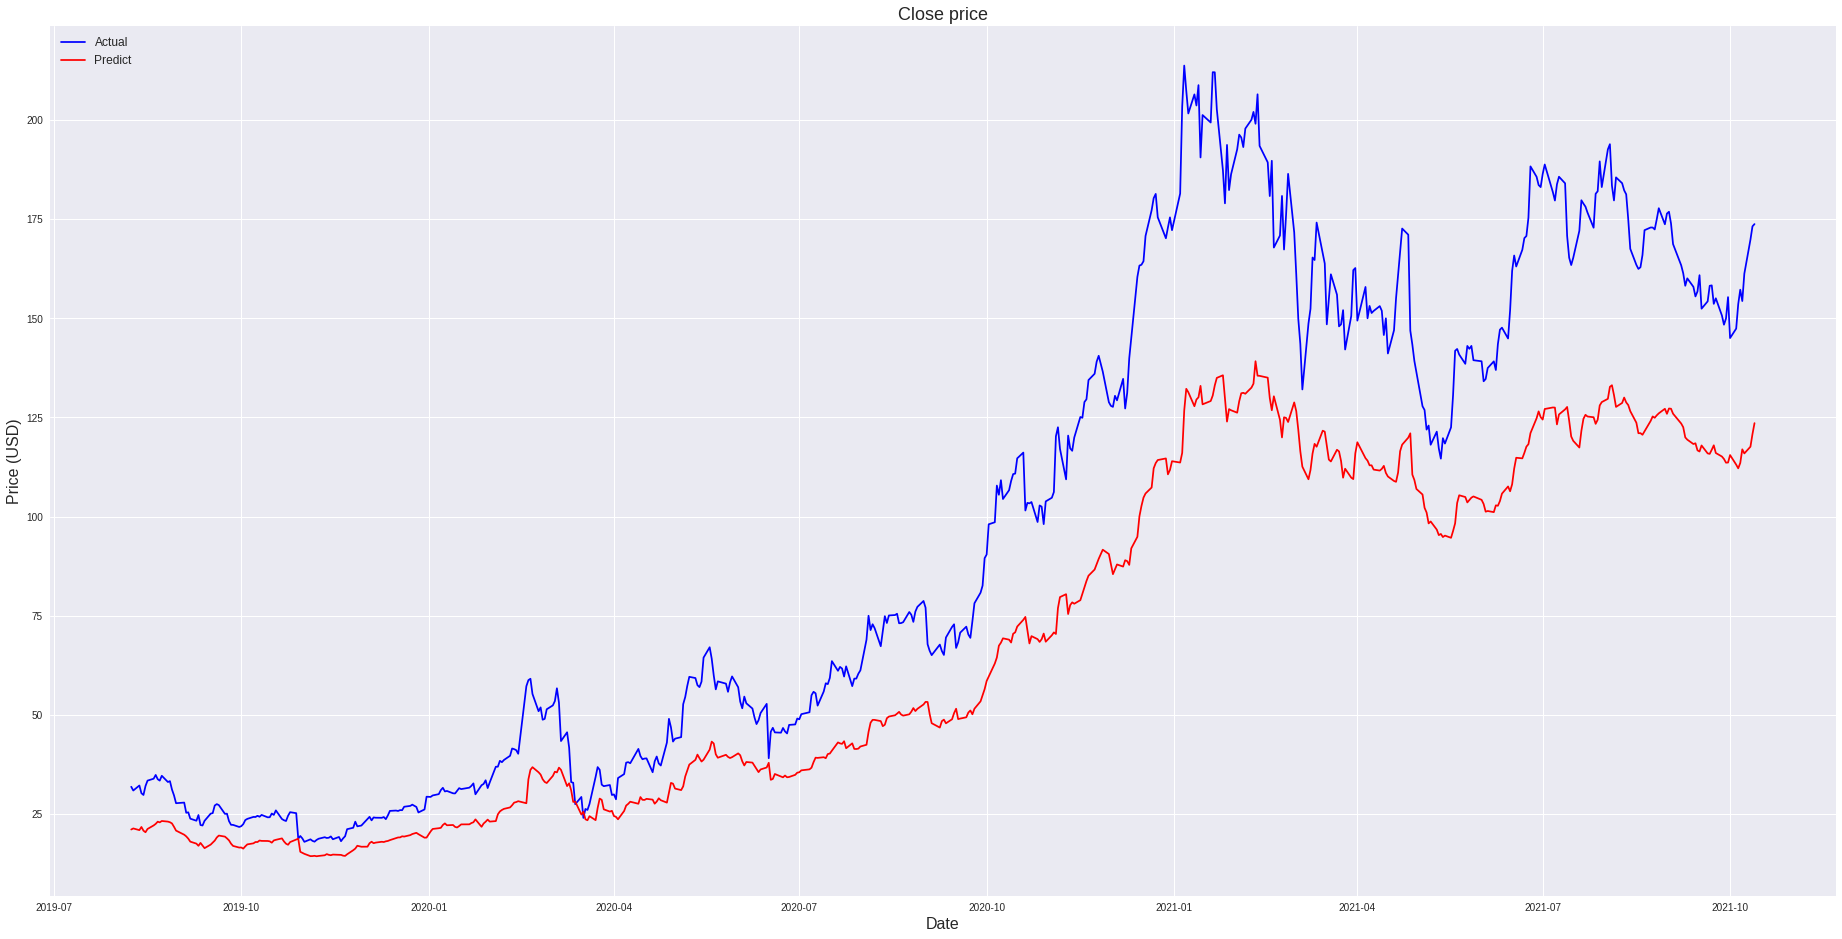

In [67]:
plot( y_close_test.sort_index().index,
     y_close_test.sort_index(),
     y_close_pred_best_svr,
     #Xtrain = y_close_train.sort_index().index,
     Ytrain = y_close_train.sort_index(),
     Title = "Close price",
     Xlabel = 'Date',
     Ylabel = 'Price (USD)' 
)

###Model: Simple neural network (Tensorflow)

In [38]:
normalizer = preprocessing.Normalization(axis=-1)
normalizer.adapt(np.array(x_close_train))
#print(normalizer.mean.numpy())


In [39]:

simple_model = tf.keras.Sequential(
    [
        normalizer,
        layers.Dense(16, activation="relu", name="layer1"),
        layers.Dense(8, activation="relu", name="layer2"),
        layers.Dense(4, activation="relu", name="layer3"),
        layers.Dense(1,activation="linear", name="layer5"),
    ]
)

simple_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 32)                65        
_________________________________________________________________
layer1 (Dense)               (None, 16)                528       
_________________________________________________________________
layer2 (Dense)               (None, 8)                 136       
_________________________________________________________________
layer3 (Dense)               (None, 4)                 36        
_________________________________________________________________
layer5 (Dense)               (None, 1)                 5         
Total params: 770
Trainable params: 705
Non-trainable params: 65
_________________________________________________________________


In [40]:
simple_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mse')


In [41]:
simple_model.fit( x_close_train, y_close_train, epochs=50, verbose=0, validation_split = 0.2)


In [42]:
y_close_pred_ts = simple_model.predict(x_close_test.sort_index())
test_results = simple_model.evaluate(x_close_test, y_close_test, verbose=0)

In [43]:
result(y_close_test,y_close_pred_ts,'TS')

TS RMSE: 6.671170767282684
TS MAE:  4.6311435534690135
TS MAPE: 123.96451338711067


####Graph for Tensorflow model

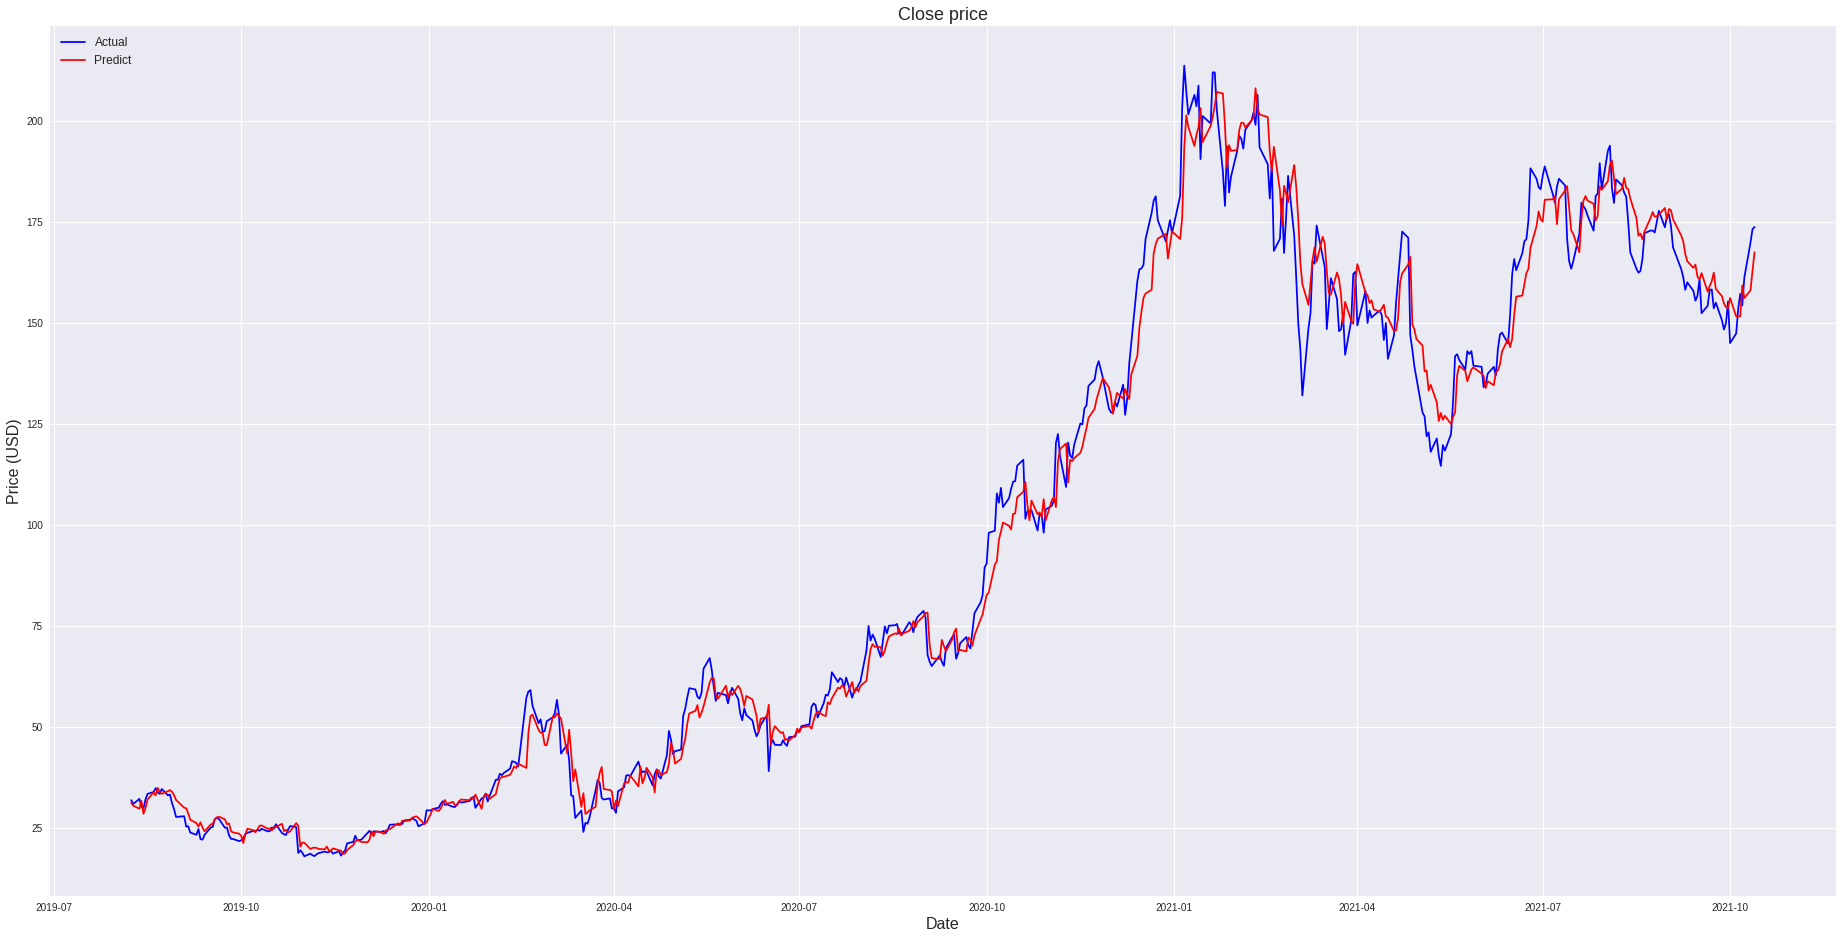

In [44]:
plot( y_close_test.sort_index().index,
     y_close_test.sort_index(),
     y_close_pred_ts,
     Xtrain = y_close_train.sort_index().index,
     #Ytrain = y_close_train.sort_index(),
     Title = "Close price",
     Xlabel = 'Date',
     Ylabel = 'Price (USD)' 
)

##**Report :**

In [45]:
print("Report for Linear Regression")
result(y_close_test,y_close_pred_ls,'LS')
print("")

print("Report for Ada Boosting")
result(y_close_test,y_close_pred_ada,'ADA')
print("")

print("Report for SVM Regression")
result(y_close_test,y_close_pred_svr,'SVM')
print("")

print("Report for Multilayer")
result(y_close_test,y_close_pred_ts,'TS')
print("")


Report for Linear Regression
LS RMSE: 4.9968485955174975
LS MAE:  3.2859992648191496
LS MAPE: 3.760139665490773

Report for Ada Boosting
ADA RMSE: 9.16273623961421
ADA MAE:  6.317866995513144
ADA MAPE: 6.913091192055619

Report for SVM Regression
SVM RMSE: 98.36744674082476
SVM MAE:  79.95795903924069
SVM MAPE: 77.28583974399442

Report for Multilayer
TS RMSE: 6.671170767282684
TS MAE:  4.6311435534690135
TS MAPE: 123.96451338711067

